In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, time
DC_ROOT = "/content/drive/MyDrive/dark circles"   # your dataset root on Drive
RESULTS_DIR = os.path.join(DC_ROOT, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

# Optional: unique run name (timestamp)
RUN_NAME = time.strftime("run_%Y%m%d_%H%M%S")
print("Saving outputs to:", os.path.join(RESULTS_DIR, RUN_NAME))


Mounted at /content/drive
Saving outputs to: /content/drive/MyDrive/dark circles/results/run_20250901_163359


In [ ]:
import os

# Adjust this path to exactly where your 'dark circles' folder is in Drive
DARK_CIRCLES_FOLDER = "/content/drive/MyDrive/dark circles"
RESULTS_DIR = os.path.join(DARK_CIRCLES_FOLDER, "results")


In [ ]:
import os
print("Outputs will appear in:", os.path.join(RESULTS_DIR, "run1"))


Outputs will appear in: /content/drive/MyDrive/dark circles/results/run1


In [ ]:
# Check GPU is T4 and CUDA is visible
import subprocess, torch, platform, os, sys
print("Python:", sys.version.split()[0], "| PyTorch:", torch.__version__)
gpu_name = subprocess.check_output("nvidia-smi --query-gpu=name --format=csv,noheader", shell=True).decode().strip()
print("GPU:", gpu_name)
assert "T4" in gpu_name or gpu_name, "No GPU detected. Go to Runtime → Change runtime type → GPU."

# Fresh install (pinned for stability)
!pip -q install --upgrade ultralytics==8.3.176

import ultralytics
from ultralytics import YOLO
print("Ultralytics:", ultralytics.__version__)


Python: 3.11.13 | PyTorch: 2.6.0+cu124
GPU: Tesla T4
Ultralytics: 8.3.176


In [ ]:
import os, glob, yaml

# Replace with the exact path where your dataset folder resides in MyDrive
DATA_ROOT = "/content/drive/MyDrive/dark circles"

# Path to your existing data.yaml
USER_YAML = os.path.join(DATA_ROOT, "data.yaml")
assert os.path.exists(USER_YAML), f"data.yaml not found at: {USER_YAML}"
print("Using YAML:", USER_YAML)

with open(USER_YAML, "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)
print("\n[data.yaml contents]\n", cfg)

# Resolve train/val image and label directories (assuming standard layout)
YAML_DIR = DATA_ROOT
train_images = os.path.join(DATA_ROOT, cfg["train"])
val_images = os.path.join(DATA_ROOT, cfg["val"])
def infer_labels(p): return p.replace("images", "labels")
train_labels = infer_labels(train_images)
val_labels = infer_labels(val_images)

# Check directories
for name, path in [("train_images", train_images), ("train_labels", train_labels),
                   ("val_images", val_images), ("val_labels", val_labels)]:
    print(f"[check] {name}: {path} ->", "OK" if os.path.exists(path) else "MISSING")


Using YAML: /content/drive/MyDrive/dark circles/data.yaml

[data.yaml contents]
 {'train': '/content/drive/MyDrive/dark circles/train/images', 'val': '/content/drive/MyDrive/dark circles/train/images', 'nc': 1, 'names': ['Dark Circle']}
[check] train_images: /content/drive/MyDrive/dark circles/train/images -> OK
[check] train_labels: /content/drive/MyDrive/dark circles/train/labels -> OK
[check] val_images: /content/drive/MyDrive/dark circles/train/images -> OK
[check] val_labels: /content/drive/MyDrive/dark circles/train/labels -> OK


In [ ]:
import os
from pathlib import Path

def safe_symlink(src: Path, dst: Path):
    """Create a symlink, replacing it if it already exists."""
    try:
        os.symlink(src, dst)
    except FileExistsError:
        if dst.is_symlink():  # only remove if it's a symlink
            dst.unlink()       # remove existing symlink
            os.symlink(src, dst)
        else:
            raise  # existing non-symlink file should raise

In [ ]:
import os, yaml, glob, random, shutil
from pathlib import Path

# ---- EDIT ONLY THIS if needed ----
USER_YAML = "/content/drive/MyDrive/dark circles/data.yaml"  # your screenshot path
# ----------------------------------

assert os.path.exists(USER_YAML), f"data.yaml not found at: {USER_YAML}"
with open(USER_YAML, "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

root = Path(USER_YAML).parent
def p(x): return (root / x).resolve()

train_images = p(cfg["train"])
val_images   = p(cfg["val"])
train_labels = Path(str(train_images).replace("/images", "/labels"))
val_labels   = Path(str(val_images).replace("/images", "/labels"))

print("[check] train_images:", train_images, "->", train_images.exists())
print("[check] train_labels:", train_labels, "->", train_labels.exists())
print("[check]   val_images:",   val_images, "->",   val_images.exists())
print("[check]   val_labels:",   val_labels, "->",   val_labels.exists())

# If val == train, build a TEMP 80/20 split in /content/tmp_dc with symlinks.
tmp_yaml = None
if str(train_images) == str(val_images):
    print("\n⚠️  YAML has the same folder for train and val. Creating a TEMP 80/20 split (symlinks) in /content/tmp_dc ...")
    tmp_root = Path("/content/tmp_dc")

    # Remove existing temporary directory if it exists
    if tmp_root.exists():
        shutil.rmtree(tmp_root)

    for sub in ["train/images","train/labels","val/images","val/labels"]:
        (tmp_root/sub).mkdir(parents=True, exist_ok=True)

    all_imgs = sorted([p for p in train_images.iterdir() if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}])
    random.seed(42)
    random.shuffle(all_imgs)
    cut = max(1, int(0.8*len(all_imgs)))
    tr, va = all_imgs[:cut], all_imgs[cut:]

    def link_batch(img_list, split):
        for ip in img_list:
            stem = ip.stem
            lp = train_labels / f"{stem}.txt"
            # imgs
            os.symlink(ip, tmp_root/f"{split}/images"/ip.name)
            # labels (only if exists)
            if lp.exists():
                os.symlink(lp, tmp_root/f"{split}/labels"/lp.name)
    link_batch(tr, "train")
    link_batch(va, "val")

    # build a temp yaml pointing to tmp_dc
    tmp_yaml = Path("/content/tmp_dc.yaml")
    with open(tmp_yaml, "w") as f:
        f.write(f"path: /content/tmp_dc\ntrain: train/images\nval: val/images\nnames: ['Dark Circle']\nnc: 1\n")
    data_yaml_to_use = str(tmp_yaml)
    print("✅ Temp split ready. Using YAML:", data_yaml_to_use)
else:
    data_yaml_to_use = USER_YAML
    print("✅ Using your YAML as-is:", data_yaml_to_use)

# ---- counts (clean = missing/empty txt) ----
def counts(img_dir, lbl_dir):
    imgs = [p for p in Path(img_dir).iterdir() if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}]
    dark = clean = 0
    for ip in imgs:
        txt = Path(lbl_dir)/f"{ip.stem}.txt"
        if not txt.exists():
            clean += 1
        else:
            with open(txt, "r", encoding="utf-8", errors="ignore") as f:
                has_obj = any(line.strip() for line in f)
            if has_obj: dark += 1
            else: clean += 1
    return len(imgs), dark, clean

if tmp_yaml:  # use temp dirs for counts
    ti, tl = "/content/tmp_dc/train/images", "/content/tmp_dc/train/labels"
    vi, vl = "/content/tmp_dc/val/images",   "/content/tmp_dc/val/labels"
else:
    ti, tl = str(train_images), str(train_labels)
    vi, vl = str(val_images),   str(val_labels)

t_total, t_dark, t_clean = counts(ti, tl)
v_total, v_dark, v_clean = counts(vi, vl)
print(f"\n=== Dataset Summary ===")
print(f"train: total={t_total} | darkcircle={t_dark} | clean={t_clean}")
print(f"  val: total={v_total} | darkcircle={v_dark} | clean={v_clean}")

[check] train_images: /content/drive/MyDrive/dark circles/train/images -> True
[check] train_labels: /content/drive/MyDrive/dark circles/train/labels -> True
[check]   val_images: /content/drive/MyDrive/dark circles/train/images -> True
[check]   val_labels: /content/drive/MyDrive/dark circles/train/labels -> True

⚠️  YAML has the same folder for train and val. Creating a TEMP 80/20 split (symlinks) in /content/tmp_dc ...
✅ Temp split ready. Using YAML: /content/tmp_dc.yaml

=== Dataset Summary ===
train: total=1611 | darkcircle=886 | clean=725
  val: total=403 | darkcircle=228 | clean=175


In [ ]:
!pip -q install ultralytics==8.3.176
from ultralytics import YOLO

USER_YAML = os.path.join(DC_ROOT, "data.yaml")   # you already validated this
model = YOLO("yolo11n.pt")

results = model.train(
    data=USER_YAML,
    imgsz=640,
    epochs=20,
    batch=-1,
    device=0,
    optimizer="SGD",
    lr0=0.01, lrf=0.01, cos_lr=True,
    momentum=0.937, weight_decay=0.0005,
    patience=10, amp=True,
    translate=0.1, scale=0.5, fliplr=0.5,
    mosaic=0.8, mixup=0.1,
    project=RESULTS_DIR,   # <- saves into Drive
    name=RUN_NAME,         # results/<RUN_NAME>/
    exist_ok=True,
    plots=True             # generates results.png, PR_curve.png, confusion_matrix.png, etc.
)


Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/dark circles/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.8, multi_scale=False, name=run_20250809_151352, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=10, perspective=0.0, plots=Tru

train: Scanning /content/drive/MyDrive/dark circles/train/labels... 1114 images, 900 backgrounds, 0 corrupt: 100%|██████████| 2014/2014 [00:42<00:00, 47.20it/s] 


train: New cache created: /content/drive/MyDrive/dark circles/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1611, len(boxes) = 1938. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.74G total, 0.10G reserved, 0.06G allocated, 14.58G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2590035       6.441         0.461         45.79         329.1        (1, 3, 640, 640)                    list
     2590035       12.88 

train: Scanning /content/drive/MyDrive/dark circles/train/labels.cache... 1114 images, 900 backgrounds, 0 corrupt: 100%|██████████| 2014/2014 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1611, len(boxes) = 1938. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 4.4±4.9 ms, read: 4.3±3.7 MB/s, size: 23.5 KB)


val: Scanning /content/drive/MyDrive/dark circles/train/labels.cache... 1114 images, 900 backgrounds, 0 corrupt: 100%|██████████| 2014/2014 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1611, len(boxes) = 1938. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to /content/drive/MyDrive/dark circles/results/run_20250809_151352/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0004453125), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/dark circles/results/run_20250809_151352
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.65G      2.529      4.807      1.983         30        640: 100%|██████████| 36/36 [00:40<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


                   all       2014       1938    0.00148      0.463    0.00158   0.000482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      7.32G      2.193      2.534      1.789         20        640: 100%|██████████| 36/36 [00:36<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:17<00:00,  1.03it/s]


                   all       2014       1938    0.00289      0.536     0.0367    0.00808

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      7.33G      2.226      2.209      1.726         29        640: 100%|██████████| 36/36 [00:37<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:20<00:00,  1.11s/it]


                   all       2014       1938      0.258     0.0779     0.0643     0.0161

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      7.34G      2.293      2.217      1.772         24        640: 100%|██████████| 36/36 [00:35<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:20<00:00,  1.13s/it]


                   all       2014       1938      0.021     0.0191    0.00378    0.00102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      7.34G      2.234      2.031      1.704         15        640: 100%|██████████| 36/36 [00:36<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:18<00:00,  1.02s/it]


                   all       2014       1938      0.278      0.414      0.218     0.0672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      7.35G      2.183      1.934      1.701         25        640: 100%|██████████| 36/36 [00:38<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


                   all       2014       1938      0.315      0.296      0.207     0.0627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      7.35G      2.118      1.816      1.671         21        640: 100%|██████████| 36/36 [00:36<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:19<00:00,  1.06s/it]


                   all       2014       1938     0.0736       0.41     0.0686     0.0218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      7.35G      2.111      1.671      1.631         29        640: 100%|██████████| 36/36 [00:37<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:19<00:00,  1.09s/it]


                   all       2014       1938      0.576      0.642      0.587      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      7.35G      2.072      1.646      1.594         32        640: 100%|██████████| 36/36 [00:37<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]


                   all       2014       1938      0.575      0.653      0.583      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      7.35G      2.072       1.63      1.626         25        640: 100%|██████████| 36/36 [00:36<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]

                   all       2014       1938      0.639      0.684      0.667      0.245


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      7.35G      1.962      1.487       1.63         10        640: 100%|██████████| 36/36 [00:38<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]

                   all       2014       1938      0.629      0.666      0.641      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      7.35G      1.946       1.41      1.634         17        640: 100%|██████████| 36/36 [00:33<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:17<00:00,  1.03it/s]

                   all       2014       1938      0.623      0.718      0.643      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      7.35G      1.929      1.389      1.611         20        640: 100%|██████████| 36/36 [00:35<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:16<00:00,  1.09it/s]

                   all       2014       1938      0.718      0.782      0.762      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      7.35G      1.893      1.314      1.555         13        640: 100%|██████████| 36/36 [00:35<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:17<00:00,  1.03it/s]

                   all       2014       1938      0.726      0.808      0.783      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      7.35G      1.852      1.285      1.543         21        640: 100%|██████████| 36/36 [00:35<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:16<00:00,  1.07it/s]

                   all       2014       1938      0.715        0.8      0.778      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      7.35G      1.833      1.244      1.523         17        640: 100%|██████████| 36/36 [00:35<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:17<00:00,  1.04it/s]

                   all       2014       1938      0.782      0.842      0.848      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      7.35G      1.814      1.227      1.517         25        640: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:16<00:00,  1.08it/s]

                   all       2014       1938       0.78      0.842      0.835      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      7.35G      1.765      1.201      1.481         17        640: 100%|██████████| 36/36 [00:35<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:16<00:00,  1.12it/s]

                   all       2014       1938      0.814       0.85      0.866      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      7.35G      1.755      1.178      1.457         17        640: 100%|██████████| 36/36 [00:35<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:16<00:00,  1.10it/s]

                   all       2014       1938      0.806      0.857      0.862      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      7.35G      1.741      1.172      1.459         17        640: 100%|██████████| 36/36 [00:37<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:16<00:00,  1.07it/s]

                   all       2014       1938       0.81      0.867      0.869      0.415



20 epochs completed in 0.315 hours.
Optimizer stripped from /content/drive/MyDrive/dark circles/results/run_20250809_151352/weights/last.pt, 5.5MB
Optimizer stripped from /content/drive/MyDrive/dark circles/results/run_20250809_151352/weights/best.pt, 5.5MB

Validating /content/drive/MyDrive/dark circles/results/run_20250809_151352/weights/best.pt...
Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


                   all       2014       1938      0.808      0.869      0.869      0.414
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to /content/drive/MyDrive/dark circles/results/run_20250809_151352


Run dir: /content/drive/MyDrive/dark circles/results/run_20250809_151352


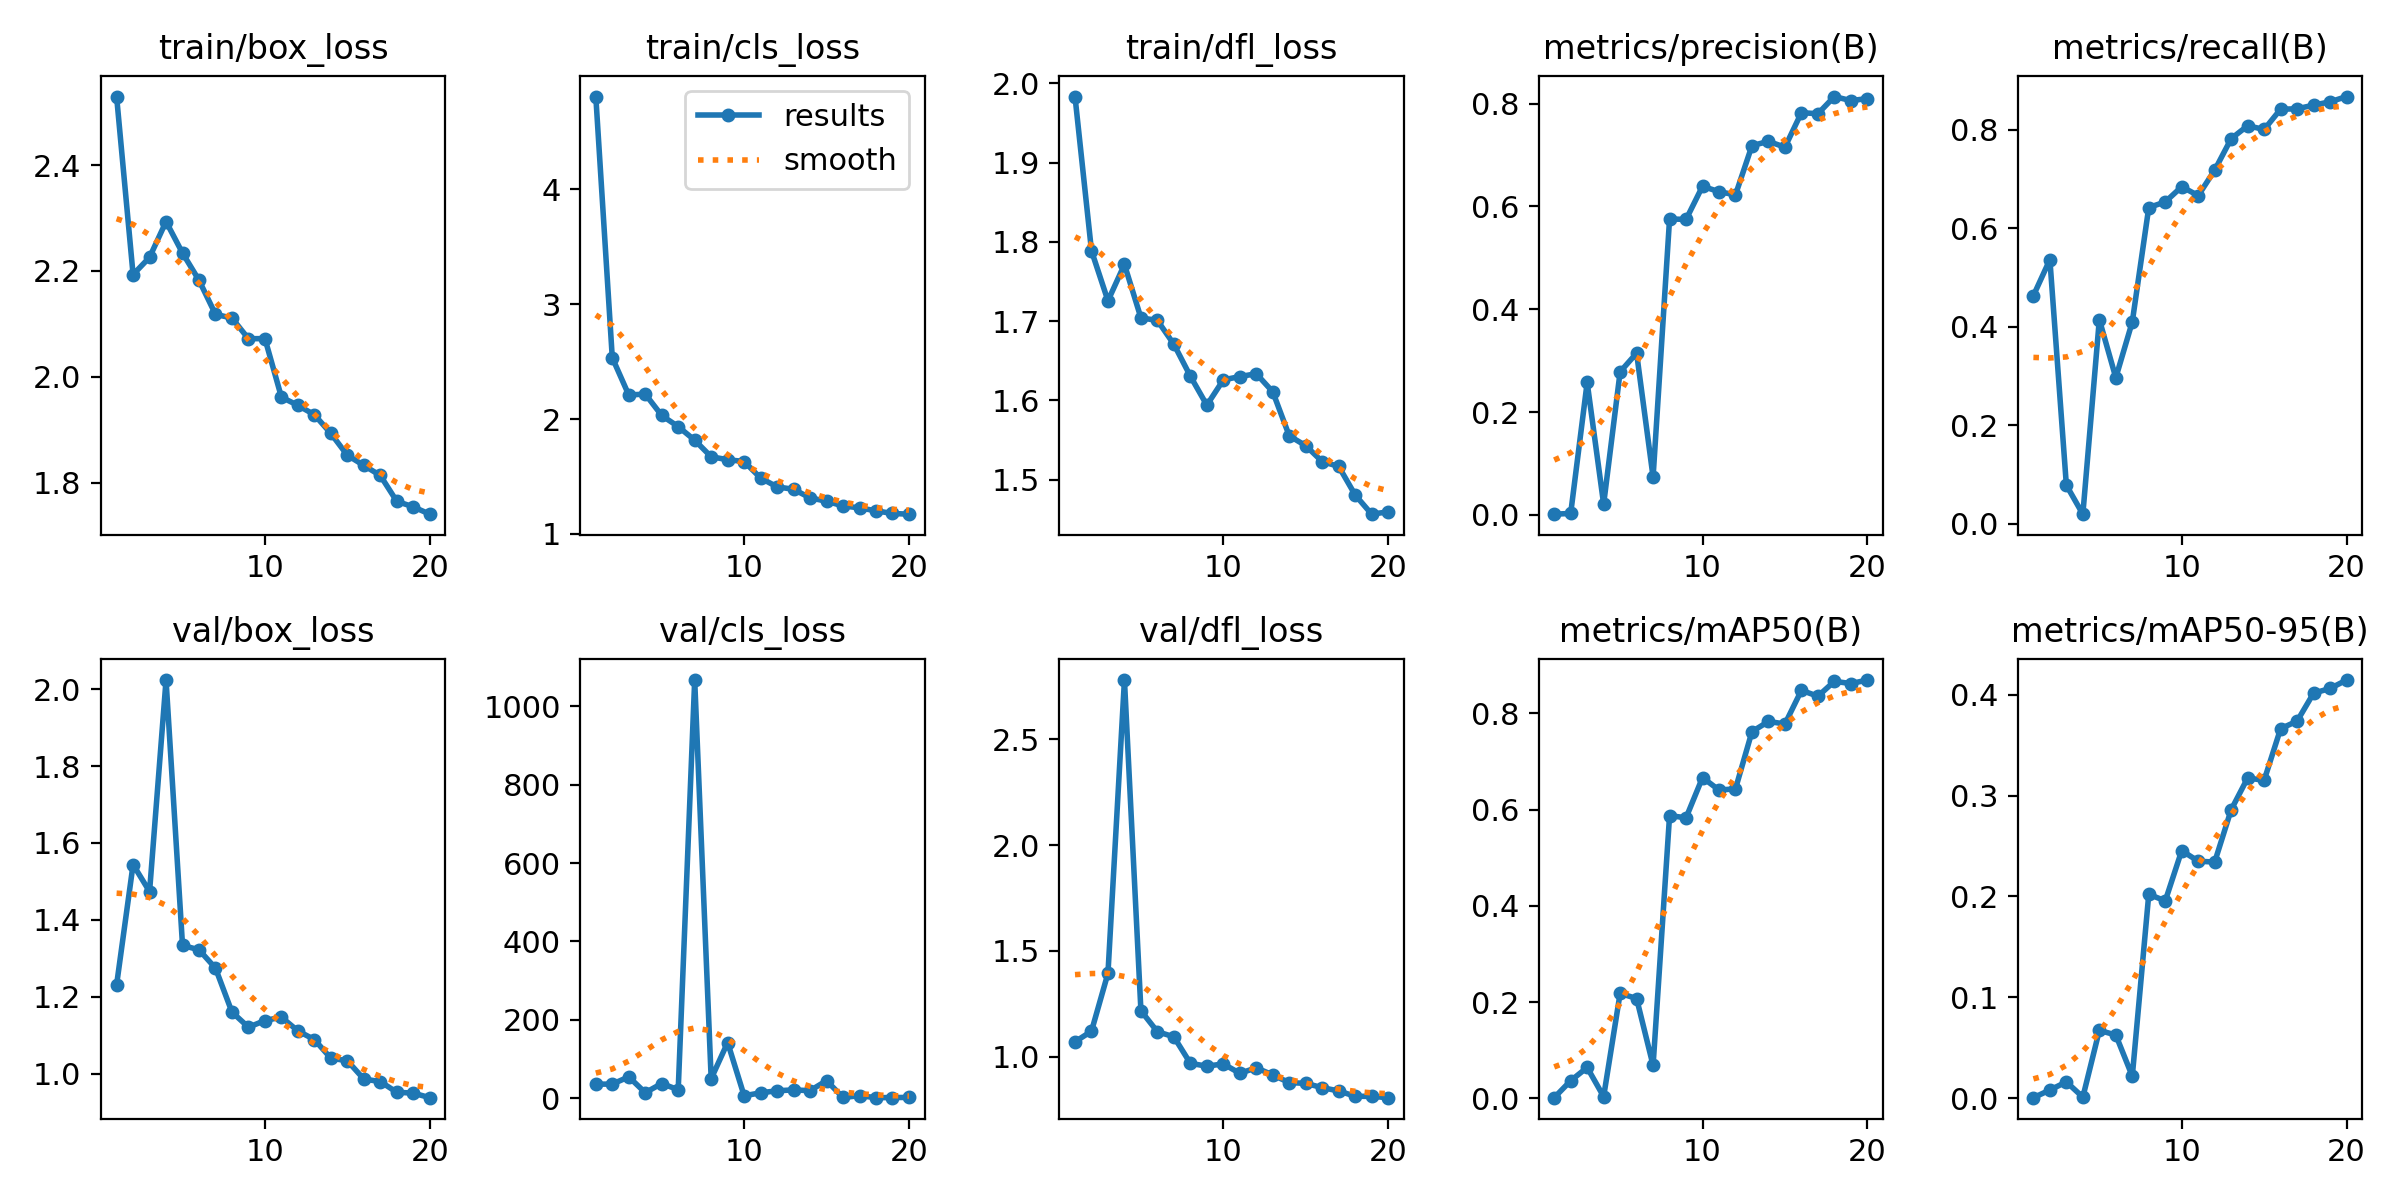

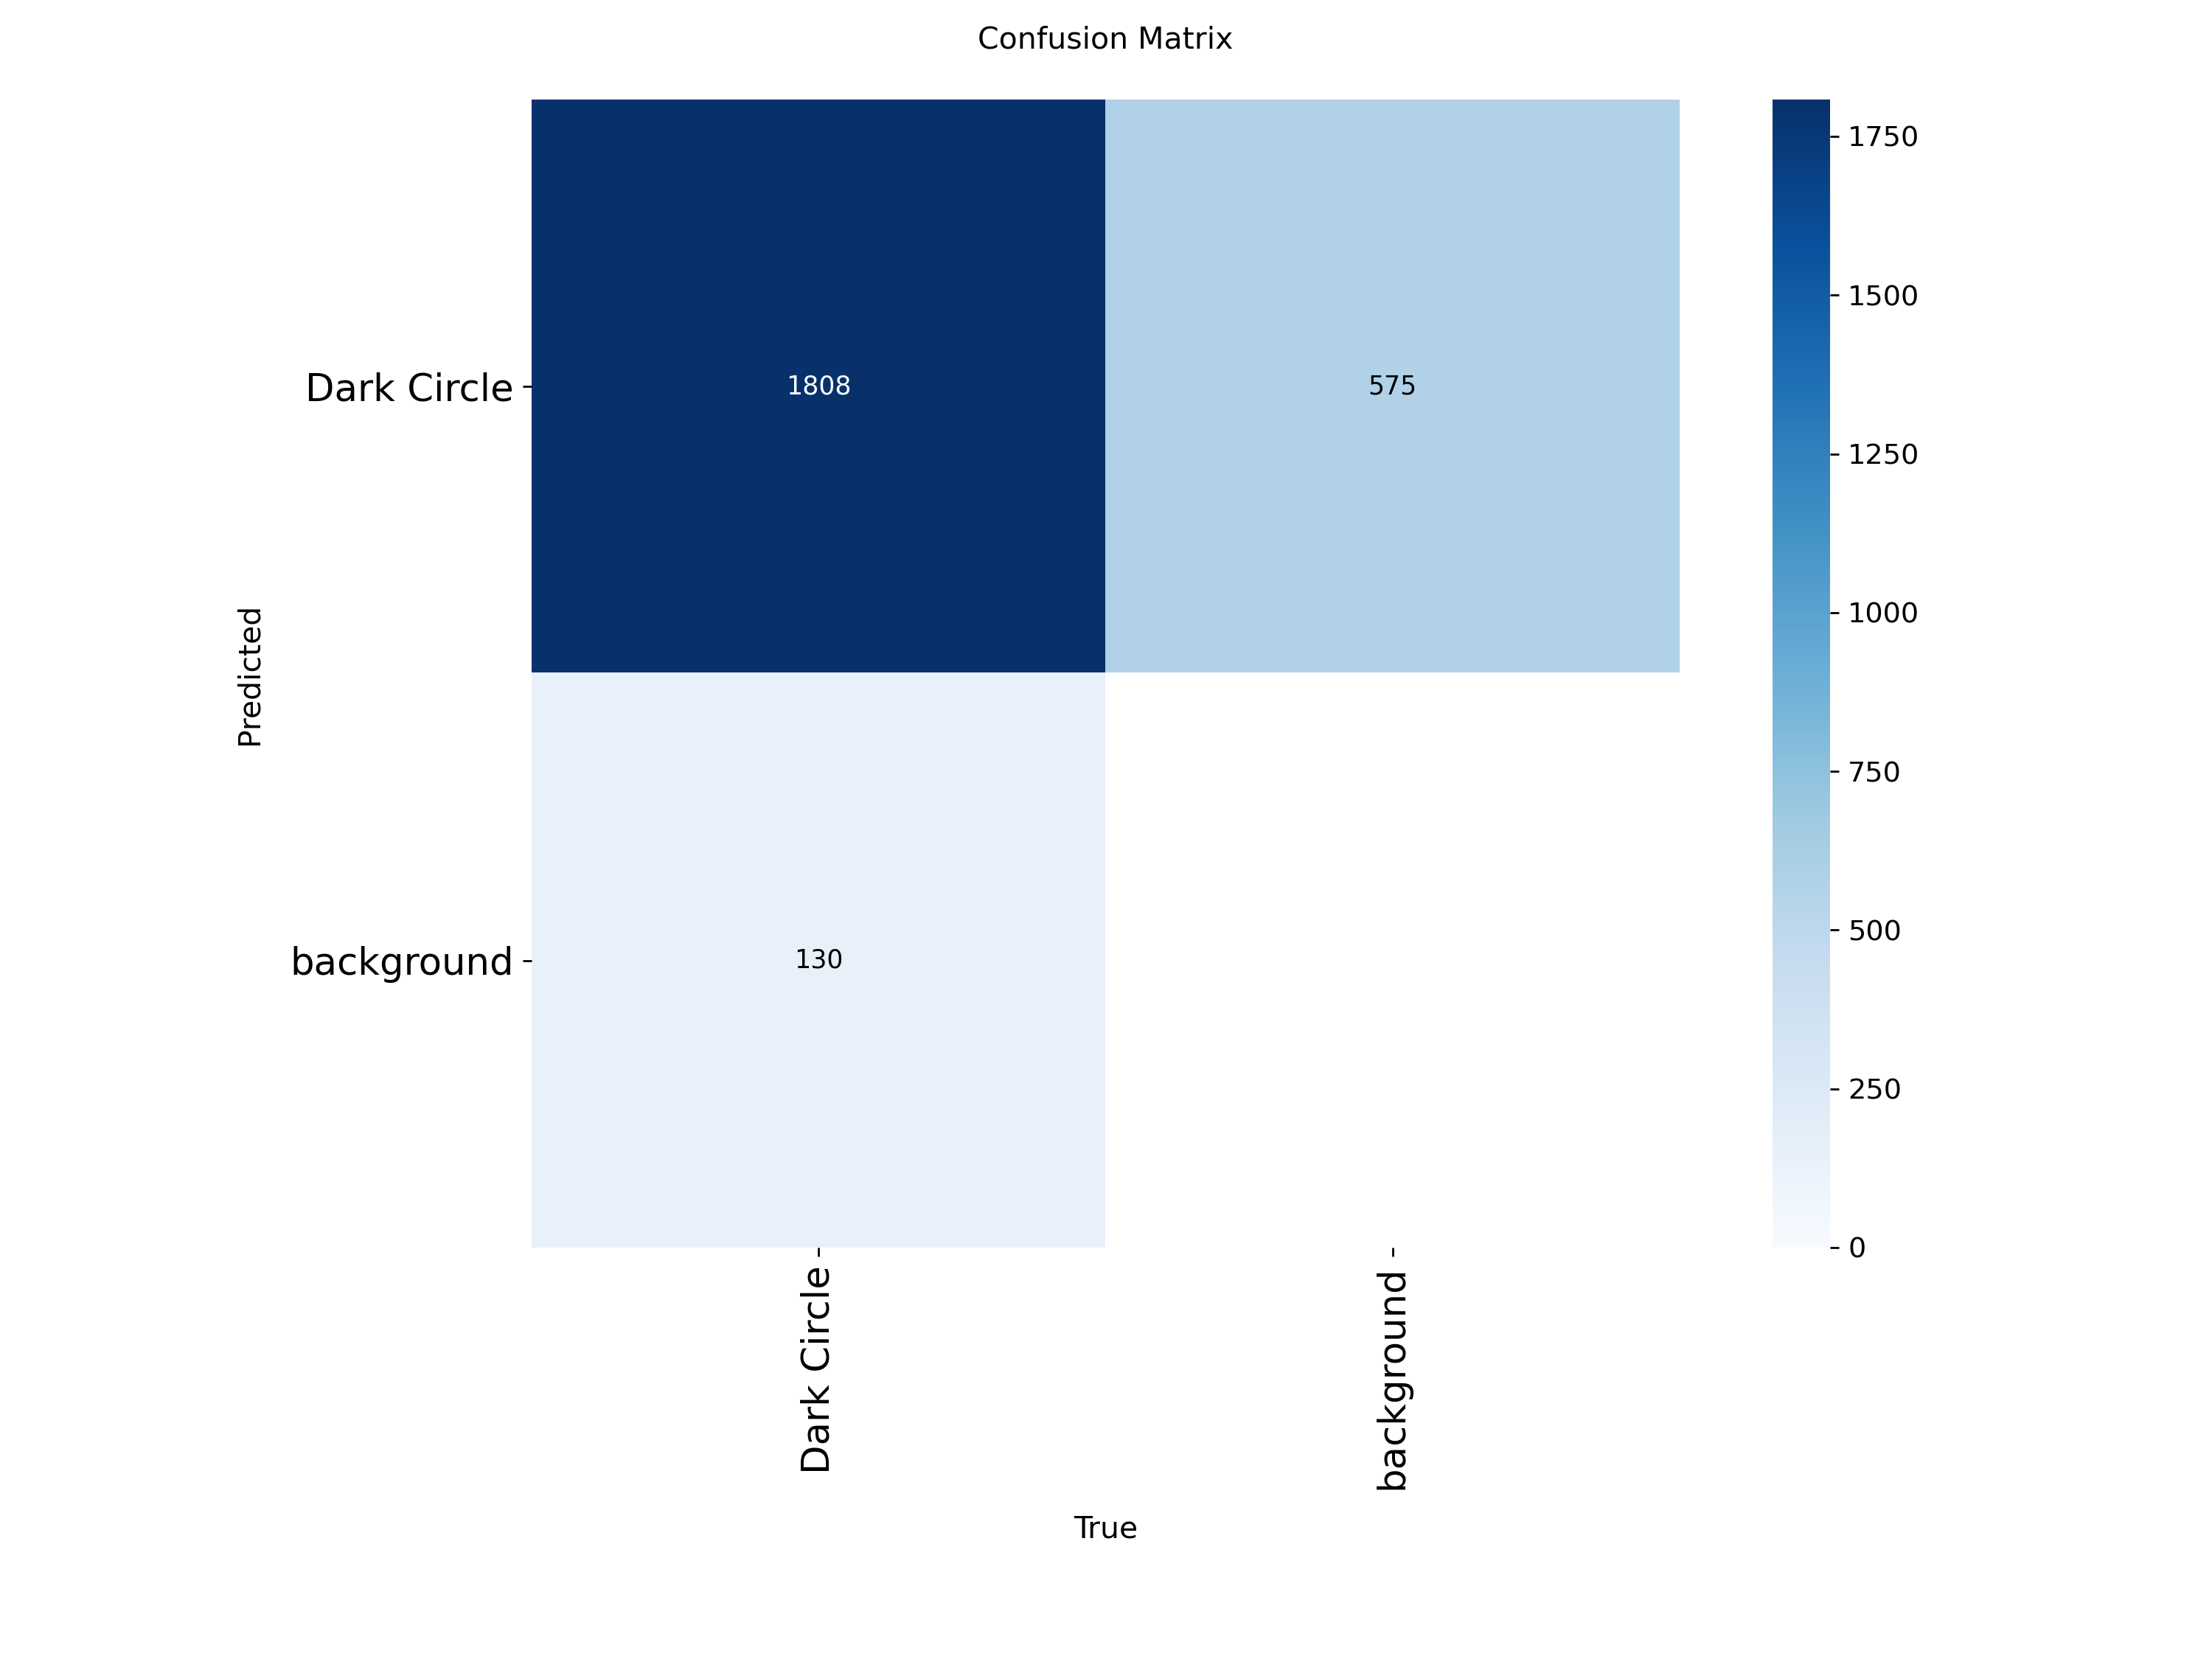

In [ ]:
import os, json, glob
from IPython.display import Image, display

run_dir = os.path.join(RESULTS_DIR, RUN_NAME)
print("Run dir:", run_dir)

# compact metrics from results.json (written by val/train)
metrics_json = os.path.join(run_dir, "results.json")
if os.path.exists(metrics_json):
    with open(metrics_json) as f: m = json.load(f)
    print("\n=== YOLO Validation Metrics (best) ===")
    for k in ["metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)"]:
        if k in m: print(f"{k}: {m[k]:.4f}")

for pf in ["results.png","confusion_matrix.png","PR_curve.png","F1_curve.png","P_curve.png","R_curve.png"]:
    p = os.path.join(run_dir, pf)
    if os.path.exists(p): display(Image(filename=p))


In [ ]:
import os, glob
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from ultralytics import YOLO

# paths from YAML (images folder for val; labels inferred by replacing 'images'->'labels')
import yaml
with open(USER_YAML, "r") as f:
    cfg = yaml.safe_load(f)
val_images = Path(os.path.join(DC_ROOT, cfg["val"])).resolve()
val_labels = Path(str(val_images).replace("/images", "/labels"))

# collect val image list
img_exts = {".jpg",".jpeg",".png",".bmp",".webp"}
val_list = sorted([p for p in val_images.iterdir() if p.suffix.lower() in img_exts])
print("Val images:", len(val_list))

# true labels: Not Clean=1 if label file non-empty, else Clean=0
y_true = []
for ip in val_list:
    lp = val_labels / (ip.stem + ".txt")
    if not lp.exists():
        y_true.append(0)
    else:
        with open(lp, "r", encoding="utf-8", errors="ignore") as f:
            has_box = any(line.strip() for line in f)
        y_true.append(1 if has_box else 0)

# predictions: any detection over conf -> Not Clean=1 else Clean=0
best = os.path.join(run_dir, "weights", "best.pt")
det_model = YOLO(best)
y_pred = []

# choose your confidence threshold (YOLO default is 0.25)
CONF_THRESH = 0.25

for ip in val_list:
    res = det_model.predict(source=str(ip), conf=CONF_THRESH, stream=False, verbose=False)[0]
    num_det = 0 if res.boxes is None else len(res.boxes)
    y_pred.append(1 if num_det > 0 else 0)

# reports
print("\n=== Clean‑Face Detection Report ===")
print(classification_report(
    y_true, y_pred,
    target_names=["Clean", "Not Clean"],
    digits=2
))

import numpy as np
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
print("Confusion Matrix (rows=true, cols=pred):\n", cm)


Val images: 2014

=== Clean‑Face Detection Report ===
              precision    recall  f1-score   support

       Clean       0.99      0.99      0.99       900
   Not Clean       0.99      0.99      0.99      1114

    accuracy                           0.99      2014
   macro avg       0.99      0.99      0.99      2014
weighted avg       0.99      0.99      0.99      2014

Confusion Matrix (rows=true, cols=pred):
 [[ 890   10]
 [  10 1104]]


In [ ]:
# Exact Match Accuracy (subset accuracy) + per-label report for the VAL set
import os, yaml, glob
from pathlib import Path
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from ultralytics import YOLO

# --- config you already have ---
DC_ROOT   = "/content/drive/MyDrive/dark circles"
USER_YAML = os.path.join(DC_ROOT, "data.yaml")
RUN_DIR   = sorted(glob.glob(os.path.join(DC_ROOT, "results", "run_*")))[-1]  # last run
BEST_W    = os.path.join(RUN_DIR, "weights", "best.pt")
CONF_THRESH = 0.25  # change if you like

# --- read yaml and paths ---
with open(USER_YAML, "r") as f:
    cfg = yaml.safe_load(f)

val_images = Path(os.path.join(DC_ROOT, cfg["val"])).resolve()
val_labels = Path(str(val_images).replace("/images", "/labels")).resolve()

# class names from yaml; we'll also add a synthetic "Clean" class for reporting
class_names = [str(x) for x in (cfg.get("names") or [])]
num_det_classes = len(class_names)
class_names_plus_clean = class_names + ["Clean"]
K = len(class_names_plus_clean)  # = num_det_classes + 1

# collect val images
img_exts = {".jpg",".jpeg",".png",".bmp",".webp"}
val_list = sorted([p for p in val_images.iterdir() if p.suffix.lower() in img_exts])
assert len(val_list) > 0, "No validation images found."

# --- ground truth multilabel (K = classes + Clean) ---
Y_true = np.zeros((len(val_list), K), dtype=int)
for i, ip in enumerate(val_list):
    lp = val_labels / f"{ip.stem}.txt"
    if lp.exists():
        has_box = False
        with open(lp, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 1 and parts[0].isdigit():
                    cid = int(parts[0])
                    if 0 <= cid < num_det_classes:
                        Y_true[i, cid] = 1
                        has_box = True
        if not has_box:
            Y_true[i, -1] = 1  # Clean
    else:
        Y_true[i, -1] = 1  # Clean (no label file)

# --- predictions multilabel (same K) ---
det_model = YOLO(BEST_W)
Y_pred = np.zeros_like(Y_true)
for i, ip in enumerate(val_list):
    res = det_model.predict(source=str(ip), conf=CONF_THRESH, stream=False, verbose=False)[0]
    if res.boxes is not None and len(res.boxes):
        for c in res.boxes.cls.cpu().numpy().astype(int).tolist():
            if 0 <= c < num_det_classes:
                Y_pred[i, c] = 1
    if Y_pred[i, :num_det_classes].sum() == 0:
        Y_pred[i, -1] = 1  # predicted Clean if no detections

# --- Exact Match (subset accuracy) ---
em = accuracy_score(Y_true, Y_pred)  # exact match for multilabel per sklearn
print(f"\n🎯 Exact Match Accuracy (all {K} labels): {em*100:.2f}%")

# --- Per-label precision/recall/F1 (treat each label as binary) ---
print("\n=== Per-Label Classification Report ===")
print(classification_report(Y_true, Y_pred, target_names=class_names_plus_clean, digits=2, zero_division=0))



🎯 Exact Match Accuracy (all 2 labels): 99.01%

=== Per-Label Classification Report ===
              precision    recall  f1-score   support

 Dark Circle       0.99      0.99      0.99      1114
       Clean       0.99      0.99      0.99       900

   micro avg       0.99      0.99      0.99      2014
   macro avg       0.99      0.99      0.99      2014
weighted avg       0.99      0.99      0.99      2014
 samples avg       0.99      0.99      0.99      2014



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, glob, shutil, time

DC_ROOT = "/content/drive/MyDrive/dark circles"     # your project folder
RESULTS_DIR = os.path.join(DC_ROOT, "results")      # where you trained/saved runs
RUN_DIR = sorted(glob.glob(os.path.join(RESULTS_DIR, "run_*")))[-1]  # last run folder

src = os.path.join(RUN_DIR, "weights", "best.pt")
dst = os.path.join(RESULTS_DIR, "darkcirclesmodel.pt")
assert os.path.exists(src), f"best.pt not found at {src}"
shutil.copy2(src, dst)
print("✅ Saved model as:", dst)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Saved model as: /content/drive/MyDrive/dark circles/results/darkcirclesmodel.pt


Saving The-best-under-eye-dark-circles-treatments-available-in-mumbai-india.jpg to The-best-under-eye-dark-circles-treatments-available-in-mumbai-india (1).jpg
Uploaded: ['The-best-under-eye-dark-circles-treatments-available-in-mumbai-india (1).jpg']
The-best-under-eye-dark-circles-treatments-available-in-mumbai-india (1).jpg → Dark circles present


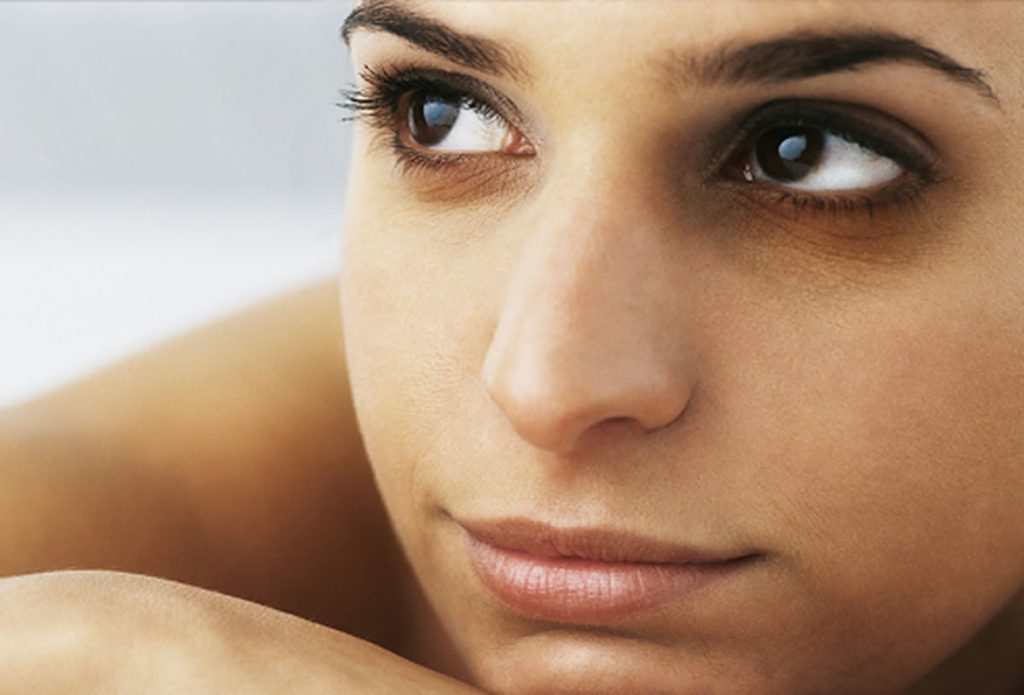

The-best-under-eye-dark-circles-treatments-available-in-mumbai-india.jpg → Dark circles present


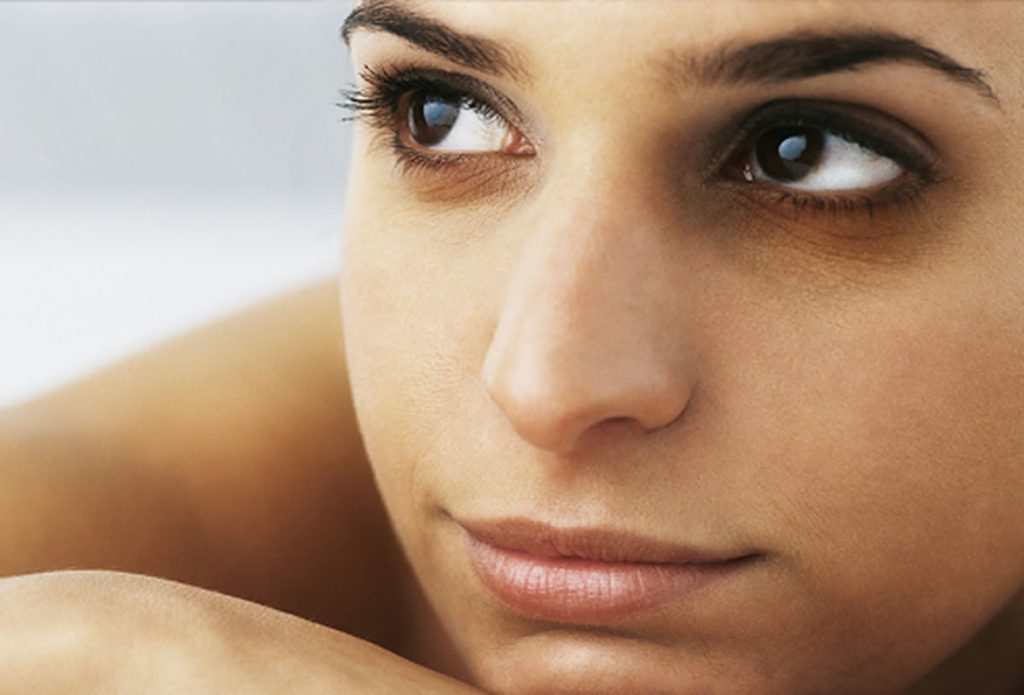

bbbb (1).webp → Dark circles present


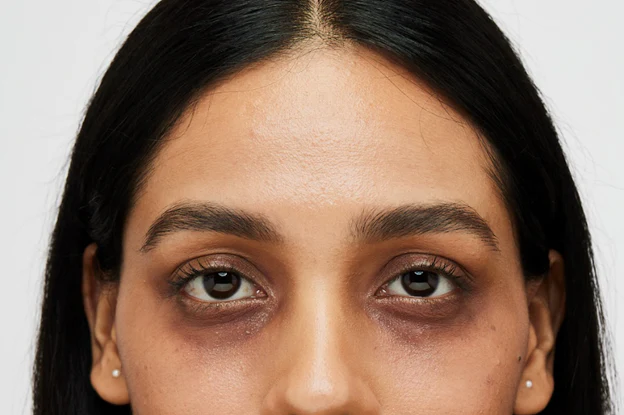

bbbb (2).webp → Dark circles present


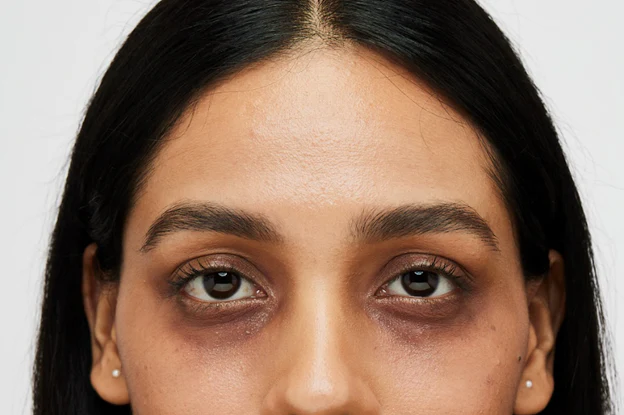

bbbb (3).webp → Dark circles present


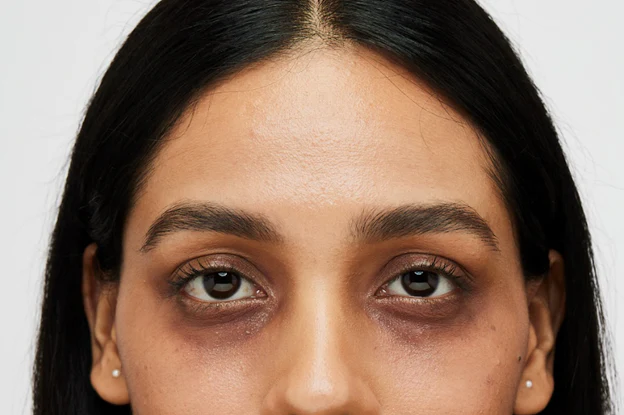

bbbb.webp → Dark circles present


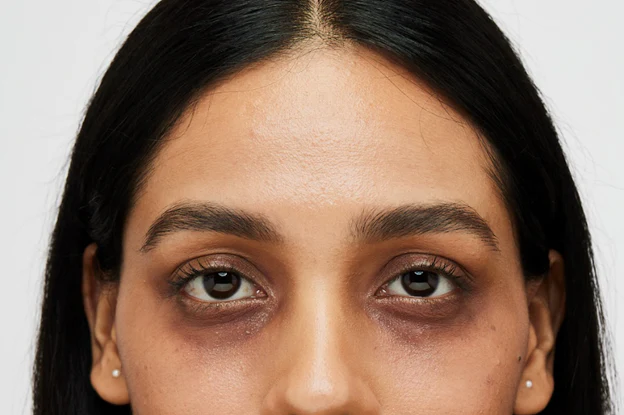

In [ ]:
from ultralytics import YOLO
from google.colab import files
from IPython.display import display, Image as IPyImage
from pathlib import Path
from PIL import Image as PILImage
import os, glob

# 1) Upload images
upload_dir = "/content/test_uploads"
os.makedirs(upload_dir, exist_ok=True)
uploaded = files.upload()
for fname, fd in uploaded.items():
    with open(os.path.join(upload_dir, fname), "wb") as f:
        f.write(fd)
print("Uploaded:", list(uploaded.keys()))

# 2) Load model
model_path = "/content/drive/MyDrive/dark circles/results/darkcirclesmodel.pt"
model = YOLO(model_path)

# 3) Predict & display
for img_path in sorted(glob.glob(os.path.join(upload_dir, "*.*"))):
    res = model.predict(source=img_path, conf=0.25, stream=False, verbose=False)[0]
    has_box = res.boxes is not None and len(res.boxes) > 0
    verdict = "Dark circles present" if has_box else "Not present"
    print(f"{Path(img_path).name} → {verdict}")

    ext = Path(img_path).suffix.lower()
    if ext == ".webp":
        tmp = img_path + ".png"
        PILImage.open(img_path).convert("RGB").save(tmp, "PNG")
        display(IPyImage(filename=tmp))
        os.remove(tmp)
    else:
        display(IPyImage(filename=img_path))


Reading from: /content/drive/MyDrive/SkinReport_Chapter4


**Table 4.1 — Dataset Summary**

,Subset,Images (clf),Acne=1,Pigmentation=1,Wrinkles=1
0,All,5062,1406,534,1022


**Table 4.2 — Classifier Test Metrics**

,Label,Precision,Recall,F1,ROC-AUC,PR-AUC
0,acne,0.963,0.998,0.980,1.000,1.000
1,pigmentation,0.834,0.996,0.908,0.999,0.991
2,wrinkles,0.865,0.990,0.923,0.998,0.996
3,Macro avg,0.887,0.995,0.937,0.999,0.996
4,Micro avg,0.903,0.995,0.947,NaN,NaN


### Classifier Highlights
- **Macro-F1**: 0.937 | **Macro ROC-AUC**: 0.999 | **Macro PR-AUC**: 0.996
- **Micro-F1**: 0.947 | **Micro Precision**: 0.903 | **Micro Recall**: 0.995

[info] YOLO metrics table not found (Table_4_4_YOLO_Metrics.csv). Skipping.


## Figures

**Figure 4.1 — Label Distribution & Co-occurrence**

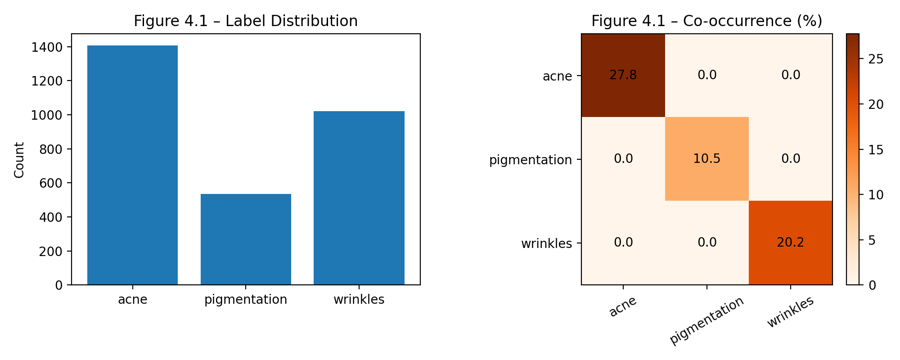

**Figure 4.2 — Preprocessing Pipeline**

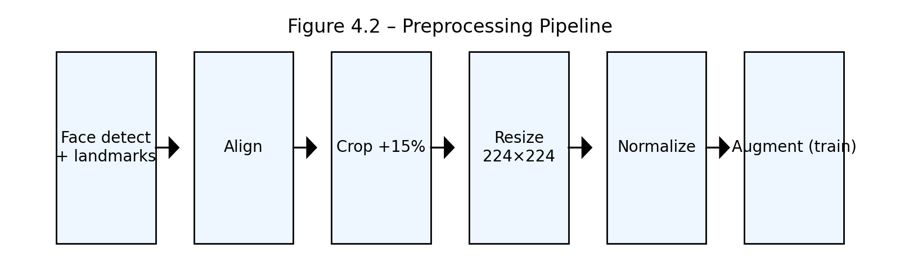

**Figure 4.4 — ROC Curves**

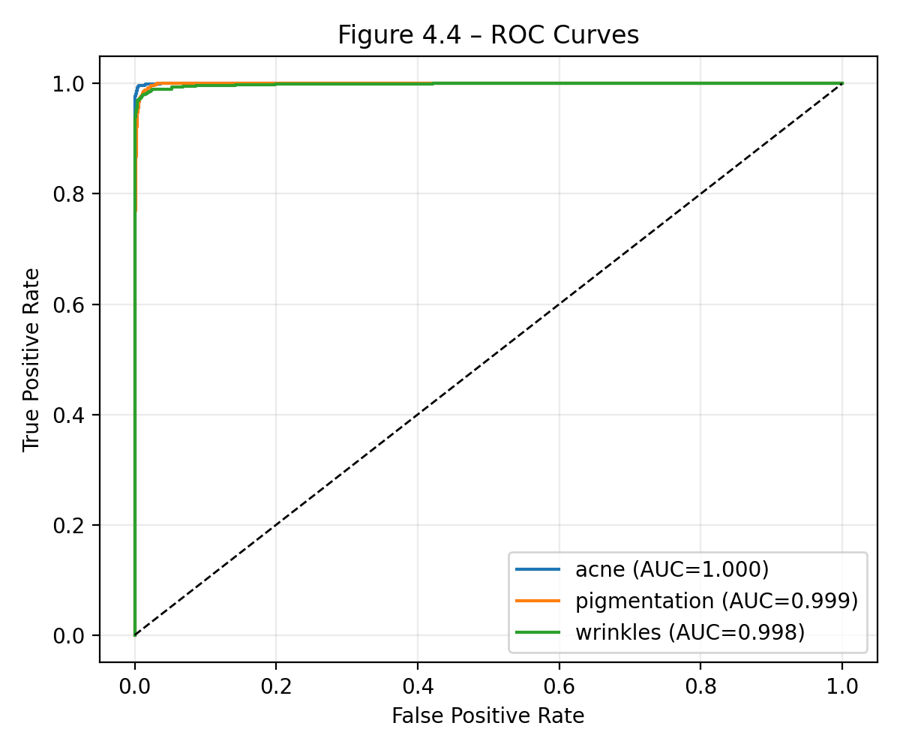

**Figure 4.4b — Precision–Recall Curves**

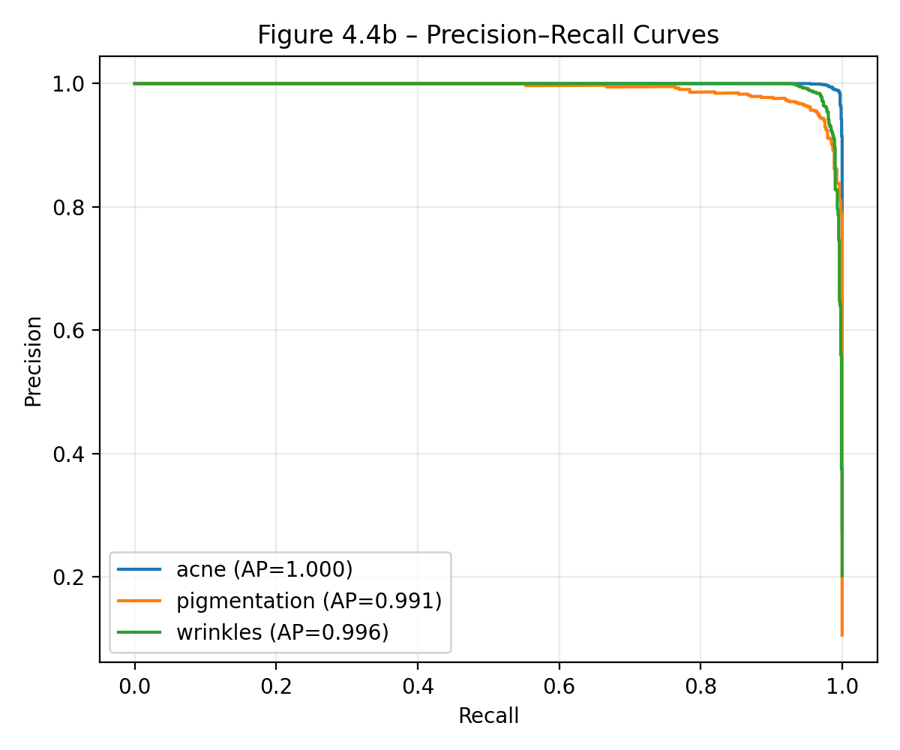

**Figure 4.5 — Confusion Matrices**

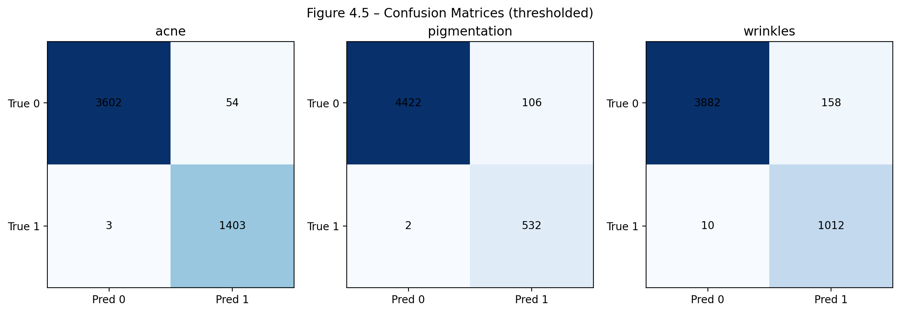

[info] Figure 4.6 (YOLO PR) not found. Skipping.


**Figure 4.7 — YOLO Example Detections**

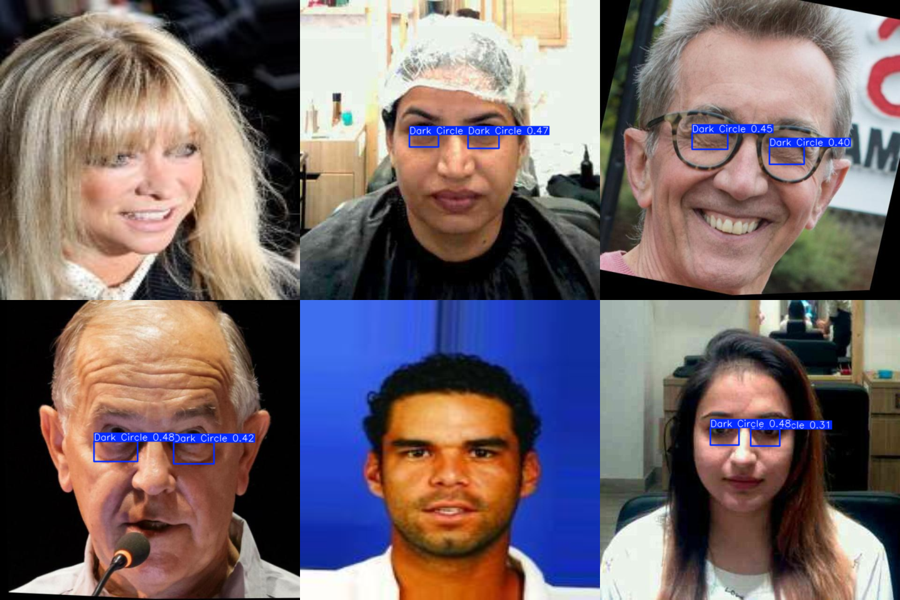

> ✅ Done: All available results were loaded from the output folder above.

In [ ]:
# ONE-CELL: Results Viewer (loads saved artifacts from OUT_DIR and renders them neatly)

# Set this to the folder where your previous cell saved outputs
OUT_DIR = "/content/drive/MyDrive/SkinReport_Chapter4"

import os, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, Markdown

def _exists(p): return p and os.path.exists(p)

def show_image(path, title=None, max_w=900):
    if not _exists(path):
        print(f"[missing] {os.path.basename(path)}")
        return
    img = Image.open(path)
    w, h = img.size
    scale = min(1.0, max_w / w) if w else 1.0
    if scale < 1.0:
        img = img.resize((int(w*scale), int(h*scale)))
    if title: display(Markdown(f"**{title}**"))
    display(img)

def load_csv(path, title=None, round_cols=("Precision","Recall","F1","ROC-AUC","PR-AUC"), ndigits=3):
    if not _exists(path):
        print(f"[missing] {os.path.basename(path)}")
        return None
    df = pd.read_csv(path)
    for c in round_cols:
        if c in df.columns:
            df[c] = df[c].astype(float).round(ndigits)
    if title: display(Markdown(f"**{title}**"))
    display(df)
    return df

print("Reading from:", OUT_DIR)

# --- Tables ---
tbl41_path = os.path.join(OUT_DIR, "Table_4_1_Dataset_Summary.csv")
tbl42_path = os.path.join(OUT_DIR, "Table_4_2_Classifier_Test_Metrics.csv")
tbl44_path = os.path.join(OUT_DIR, "Table_4_4_YOLO_Metrics.csv")  # may not exist

df41 = load_csv(tbl41_path, "Table 4.1 — Dataset Summary")
df42 = load_csv(tbl42_path, "Table 4.2 — Classifier Test Metrics")

# Metrics highlight from Table 4.2 (if present)
if df42 is not None and "Label" in df42.columns:
    # try to find macro/micro rows
    macro = df42[df42["Label"].str.lower().eq("macro avg")] if not df42.empty else None
    micro = df42[df42["Label"].str.lower().eq("micro avg")] if not df42.empty else None
    bullets = []
    if macro is not None and len(macro)==1:
        m = macro.iloc[0]
        bullets.append(f"- **Macro-F1**: {m.get('F1', np.nan):.3f} | **Macro ROC-AUC**: {m.get('ROC-AUC', np.nan):.3f} | **Macro PR-AUC**: {m.get('PR-AUC', np.nan):.3f}")
    if micro is not None and len(micro)==1:
        mi = micro.iloc[0]
        bullets.append(f"- **Micro-F1**: {mi.get('F1', np.nan):.3f} | **Micro Precision**: {mi.get('Precision', np.nan):.3f} | **Micro Recall**: {mi.get('Recall', np.nan):.3f}")
    if bullets:
        display(Markdown("### Classifier Highlights\n" + "\n".join(bullets)))

# YOLO metrics (optional)
if _exists(tbl44_path):
    _ = load_csv(tbl44_path, "Table 4.4 — YOLO Dark-Circles Metrics")
else:
    print("[info] YOLO metrics table not found (Table_4_4_YOLO_Metrics.csv). Skipping.")

# --- Figures ---
fig41 = os.path.join(OUT_DIR, "Figure_4_1_Label_Distribution_and_Cooccurrence.png")
fig42 = os.path.join(OUT_DIR, "Figure_4_2_Preprocessing_Pipeline.png")
fig44a = os.path.join(OUT_DIR, "Figure_4_4_ROC.png")
fig44b = os.path.join(OUT_DIR, "Figure_4_4b_PR.png")
fig45 = os.path.join(OUT_DIR, "Figure_4_5_Confusion_Matrices.png")
fig46 = os.path.join(OUT_DIR, "Figure_4_6_YOLO_PR.png")     # may not exist
fig47 = os.path.join(OUT_DIR, "Figure_4_7_YOLO_Examples.png")

display(Markdown("## Figures"))
show_image(fig41, "Figure 4.1 — Label Distribution & Co-occurrence")
show_image(fig42, "Figure 4.2 — Preprocessing Pipeline")
show_image(fig44a, "Figure 4.4 — ROC Curves")
show_image(fig44b, "Figure 4.4b — Precision–Recall Curves")
show_image(fig45, "Figure 4.5 — Confusion Matrices")
if _exists(fig46):
    show_image(fig46, "Figure 4.6 — YOLO PR Curve")
else:
    print("[info] Figure 4.6 (YOLO PR) not found. Skipping.")
show_image(fig47, "Figure 4.7 — YOLO Example Detections")

display(Markdown("> ✅ Done: All available results were loaded from the output folder above."))
